# Birdwatching

1. Выберите с сайта https://docs.pytorch.org/vision/0.8/datasets.html один датасет с изображениями 
2. Загрузите обучающий и тестовый датасеты
3. Выведите на экран несколько изображений обучающего датасета
4. Обучите модель VGG и ResNet модели для классификации изображений
5. Попробуйте разные оптимизаторы: SGD, Adam
6. Выведите метрики качества обученных моделей для тестовой выборки
7. Постройте и обучите модель автокодировщика
8. Для обученной модели выведите на экран настоящие и декодированные изображения

# 1. Загрузка и подготовка данных

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Subset
import warnings
warnings.filterwarnings('ignore')

# Включаем отладку CUDA
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Проверка доступности GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(f"Using device: {device}")


print("1. Загрузка данных...")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Загружаем CIFAR-10
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    
print("Датасет успешно загружен")
print(f"Классы: {trainset.classes}")
print(f"Размер тренировочного набора: {len(trainset)}")
print(f"Размер тестового набора: {len(testset)}")
    
# Создаем бинарные метки: 1 - птица, 0 - не птица
bird_class_idx = 2  # В CIFAR-10 класс "bird" имеет индекс 2

print(f"Класс 'bird' имеет индекс: {bird_class_idx}")

# Создаем кастомный датасет с бинарными метками
class BinaryBirdDataset(torch.utils.data.Dataset):
    def __init__(self, original_dataset):
        self.original_dataset = original_dataset
        self.binary_labels = []
        
        # Преобразуем метки в бинарные
        for i in range(len(original_dataset)):
            _, label = original_dataset[i]
            self.binary_labels.append(1 if label == bird_class_idx else 0)
    
    def __len__(self):
        return len(self.original_dataset)
    
    def __getitem__(self, idx):
        image, original_label = self.original_dataset[idx]
        binary_label = self.binary_labels[idx]
        return image, torch.tensor(binary_label, dtype=torch.long)

# Создаем бинарные датасеты
binary_trainset = BinaryBirdDataset(trainset)
binary_testset = BinaryBirdDataset(testset)

# Проверяем распределение классов
train_bird_count = sum(binary_trainset.binary_labels)
test_bird_count = sum(binary_testset.binary_labels)

print(f"Птиц в тренировочном наборе: {train_bird_count}/{len(binary_trainset)}")
print(f"Птиц в тестовом наборе: {test_bird_count}/{len(binary_testset)}")


Using device: cuda
1. Загрузка данных...
Files already downloaded and verified
Files already downloaded and verified
Датасет успешно загружен
Классы: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Размер тренировочного набора: 50000
Размер тестового набора: 10000
Класс 'bird' имеет индекс: 2
Птиц в тренировочном наборе: 5000/50000
Птиц в тестовом наборе: 1000/10000


In [15]:
# Создаем сбалансированные подвыборки
def create_balanced_subset(dataset, max_samples_per_class=1000):
    bird_indices = [i for i, label in enumerate(dataset.binary_labels) if label == 1]
    non_bird_indices = [i for i, label in enumerate(dataset.binary_labels) if label == 0]
    
    print(f"Доступно птиц: {len(bird_indices)}, не птиц: {len(non_bird_indices)}")
    
    # Берем равное количество примеров каждого класса
    selected_bird_indices = bird_indices[:max_samples_per_class]
    selected_non_bird_indices = non_bird_indices[:max_samples_per_class]
    selected_indices = selected_bird_indices + selected_non_bird_indices
    
    return torch.utils.data.Subset(dataset, selected_indices)

# Создаем сбалансированные датасеты
balanced_trainset = create_balanced_subset(binary_trainset, 1000)
balanced_testset = create_balanced_subset(binary_testset, 200)

# Проверяем сбалансированность
train_labels = [balanced_trainset.dataset.binary_labels[i] for i in balanced_trainset.indices]
test_labels = [balanced_testset.dataset.binary_labels[i] for i in balanced_testset.indices]

print(f"Сбалансированный тренировочный набор: {sum(train_labels)} птиц, {len(train_labels) - sum(train_labels)} не птиц")
print(f"Сбалансированный тестовый набор: {sum(test_labels)} птиц, {len(test_labels) - sum(test_labels)} не птиц")

trainloader = DataLoader(balanced_trainset, batch_size=32, shuffle=True, num_workers=0)
testloader = DataLoader(balanced_testset, batch_size=32, shuffle=False, num_workers=0)


Доступно птиц: 5000, не птиц: 45000
Доступно птиц: 1000, не птиц: 9000
Сбалансированный тренировочный набор: 1000 птиц, 1000 не птиц
Сбалансированный тестовый набор: 200 птиц, 200 не птиц


# 2. Визуализация нескольких изображений птиц


2. Визуализация изображений птиц...


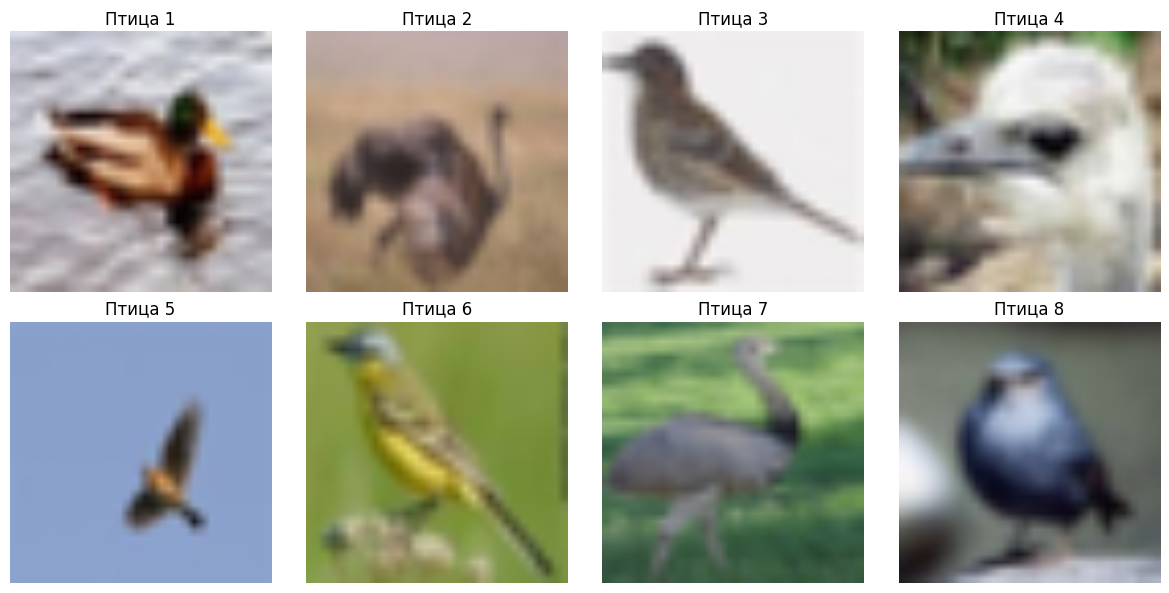

In [13]:
print("\n2. Визуализация изображений птиц...")

def imshow(img, ax, title=None):
    """Отображает одно изображение на переданной оси ax."""
    # отделяем от графа и переносим на CPU
    img = img.detach().cpu()
    # денормализация (для тензоров в формате [C,H,W])
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = (img * std + mean).clamp(0, 1)

    npimg = img.numpy().transpose(1, 2, 0)
    ax.imshow(npimg)
    if title:
        ax.set_title(title)
    ax.axis('off')

# Найдем несколько изображений птиц
bird_images = []
for images, labels in trainloader:
    for j in range(len(images)):
        if labels[j].item() == 1:  # птица имеет метку 1
            bird_images.append(images[j].cpu())
            if len(bird_images) >= 8:
                break
    if len(bird_images) >= 8:
        break

# Отобразим изображения
if bird_images:
    n = min(8, len(bird_images))
    rows, cols = 2, 4
    fig, axes = plt.subplots(rows, cols, figsize=(12, 6))
    axes = axes.flatten()

    # заранее выключим все оси, чтобы пустые клетки не мешали
    for ax in axes:
        ax.axis('off')

    for i in range(n):
        imshow(bird_images[i], axes[i], f"Птица {i+1}")

    plt.tight_layout()
    plt.show()
else:
    print("Не найдено изображений птиц!")


# 3. Создание и обучение моделей VGG и ResNet

In [ ]:
def create_model(model_name, num_classes=2):
    """Создает модель с заменой последнего слоя"""
    if model_name == 'vgg':
        model = models.vgg16(pretrained=True)
        # Заменяем последний полносвязный слой
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    elif model_name == 'resnet':
        model = models.resnet50(pretrained=True)
        # Заменяем последний полносвязный слой
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        
    return model.to(device)

def train_model(model, train_loader, test_loader, optimizer, criterion, epochs=3, model_name=""):
    """Функция для обучения модели"""
    train_losses = []
    test_accuracies = []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device).long()
            
            # Проверяем метки
            if labels.max() >= 2 or labels.min() < 0:
                print(f"Некорректные метки: min={labels.min()}, max={labels.max()}")
                continue
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            if i % 10 == 9:
                print(f'{model_name} Epoch {epoch+1}, Batch {i+1}, Loss: {running_loss/10:.4f}, Acc: {100*correct/total:.2f}%')
                running_loss = 0.0
        
        # Оценка на тестовой выборке
        model.eval()
        test_correct = 0
        test_total = 0
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device).long()
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()
        
        accuracy = 100 * test_correct / test_total
        test_accuracies.append(accuracy)
        print(f'{model_name} Epoch {epoch+1} завершена. Точность на тесте: {accuracy:.2f}%')
    
    return test_accuracies

# Определяем функцию потерь
criterion = nn.CrossEntropyLoss()


print("\nОбучение с разными оптимизаторами...")

# Модели и оптимизаторы
models_dict = {}
optimizers_config = {
    'SGD': {'optimizer': optim.SGD, 'lr': 0.001, 'momentum': 0.9},
    'Adam': {'optimizer': optim.Adam, 'lr': 0.001}
}

results = {}

for model_name in ['vgg', 'resnet']:
    for opt_name, opt_config in optimizers_config.items():
        print(f"\nОбучение {model_name} с {opt_name}...")
        
        # Создаем модель
        model = create_model(model_name, num_classes=2)
        if model is None:
            continue
        
        # Создаем оптимизатор
        if opt_name == 'SGD':
            optimizer = opt_config['optimizer'](model.parameters(), lr=opt_config['lr'], momentum=opt_config['momentum'])
        else:
            optimizer = opt_config['optimizer'](model.parameters(), lr=opt_config['lr'])
        
        # Обучаем модель
        key = f"{model_name}_{opt_name}"
        print(f"Начало обучения {key}...")
        
        try:
            results[key] = train_model(
                model, trainloader, testloader, optimizer, criterion, 
                epochs=2, model_name=key  # Уменьшаем эпохи для теста
            )
            models_dict[key] = model
            print(f"Обучение {key} завершено успешно")
        except Exception as e:
            print(f"Ошибка при обучении {key}: {e}")
            continue



5. Обучение с разными оптимизаторами...

Обучение vgg с SGD...
Начало обучения vgg_SGD...
vgg_SGD Epoch 1, Batch 10, Loss: 0.6795, Acc: 59.69%
vgg_SGD Epoch 1, Batch 20, Loss: 0.4343, Acc: 70.16%
vgg_SGD Epoch 1, Batch 30, Loss: 0.3235, Acc: 75.10%
vgg_SGD Epoch 1, Batch 40, Loss: 0.3087, Acc: 78.05%
vgg_SGD Epoch 1, Batch 50, Loss: 0.3277, Acc: 79.62%
vgg_SGD Epoch 1, Batch 60, Loss: 0.3977, Acc: 80.42%
vgg_SGD Epoch 1 завершена. Точность на тесте: 87.50%
vgg_SGD Epoch 2, Batch 10, Loss: 0.2690, Acc: 89.38%
vgg_SGD Epoch 2, Batch 20, Loss: 0.2218, Acc: 90.78%
vgg_SGD Epoch 2, Batch 30, Loss: 0.2400, Acc: 90.52%
vgg_SGD Epoch 2, Batch 40, Loss: 0.1868, Acc: 91.17%
vgg_SGD Epoch 2, Batch 50, Loss: 0.2414, Acc: 90.69%
vgg_SGD Epoch 2, Batch 60, Loss: 0.2307, Acc: 90.89%
vgg_SGD Epoch 2 завершена. Точность на тесте: 87.25%
Обучение vgg_SGD завершено успешно

Обучение vgg с Adam...
Начало обучения vgg_Adam...
vgg_Adam Epoch 1, Batch 10, Loss: 5.9492, Acc: 49.06%
vgg_Adam Epoch 1, Batch 20

# 4. Вывод метрик качества


Результаты на тестовой выборке:
Модель		Точность	Precision	Recall		F1-Score
-----------------------------------------------------------------
vgg_SGD         87.25%		0.8225		0.9500		0.8817


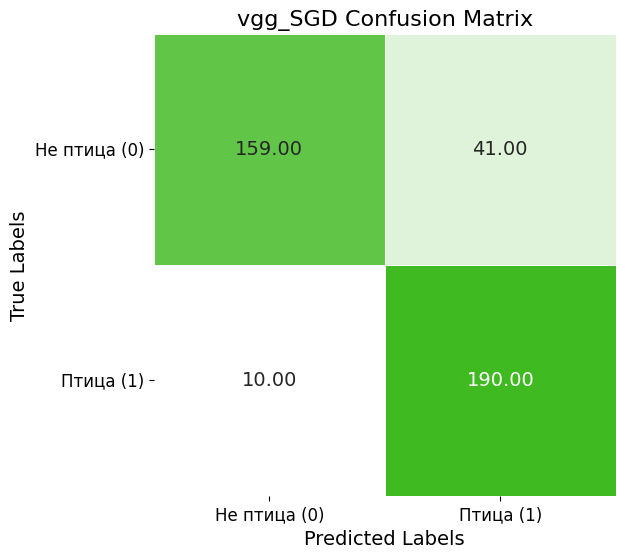


vgg_SGD Confusion Matrix (Counts):
[[159  41]
 [ 10 190]]
vgg_Adam        50.00%		0.0000		0.0000		0.0000


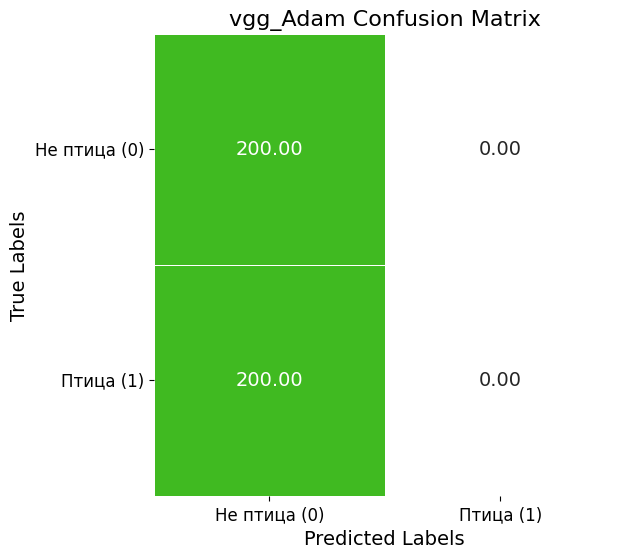


vgg_Adam Confusion Matrix (Counts):
[[200   0]
 [200   0]]
resnet_SGD      93.75%		0.9581		0.9150		0.9361


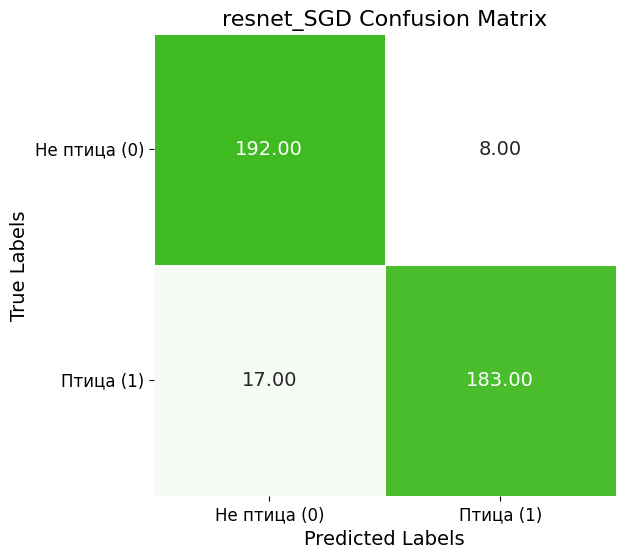


resnet_SGD Confusion Matrix (Counts):
[[192   8]
 [ 17 183]]
resnet_Adam     57.75%		0.5452		0.9350		0.6888


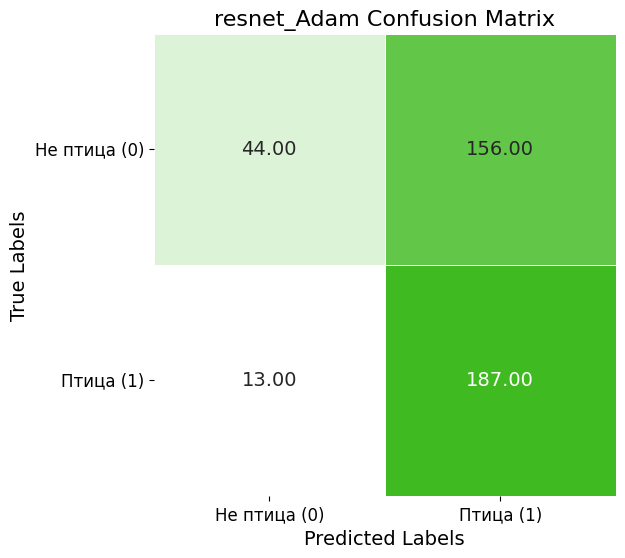


resnet_Adam Confusion Matrix (Counts):
[[ 44 156]
 [ 13 187]]


In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def evaluate_model(model, test_loader):
    """Оценка модели на тестовой выборке"""
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = 100 * correct / total
    
    # Расчет precision, recall, f1-score
    from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
    
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')
    cm = confusion_matrix(all_labels, all_preds)
    
    return accuracy, precision, recall, f1, cm


print("\nРезультаты на тестовой выборке:")
print("Модель\t\tТочность\tPrecision\tRecall\t\tF1-Score")
print("-" * 65)


corp_col = '#40ba21'

# Создаем градиентную цветовую карту
def create_gradient_cmap(hex_color):
    rgb_color = tuple(int(hex_color[i:i+2], 16)/255 for i in (1, 3, 5))
    return LinearSegmentedColormap.from_list("", [(1, 1, 1), rgb_color])

# Оценка моделей на тестовых данных
results = {}
c_map = create_gradient_cmap(corp_col)

for key, model in models_dict.items():
    accuracy, precision, recall, f1, cm = evaluate_model(model, testloader)
    print(f"{key:<15} {accuracy:.2f}%\t\t{precision:.4f}\t\t{recall:.4f}\t\t{f1:.4f}")
    
    # Нормализуем матрицу для лучшей визуализации
    cm_normalized = cm#.astype('float')# / cm.sum(axis=1)[:, np.newaxis]
    
    # Строим матрицу ошибок
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm_normalized, 
        annot=True, 
        fmt=".2f", 
        cmap=c_map, 
        linewidths=.5, 
        square=True,
        cbar=False,
        annot_kws={"size": 14}
    )
    plt.title(f'{key} Confusion Matrix', fontsize=16)
    plt.xlabel('Predicted Labels', fontsize=14)
    plt.ylabel('True Labels', fontsize=14)
    plt.xticks([0.5, 1.5], ['Не птица (0)', 'Птица (1)'], fontsize=12)
    plt.yticks([0.5, 1.5], ['Не птица (0)', 'Птица (1)'], fontsize=12, rotation=0)
    plt.show()
    
    # Выводим числовые значения матрицы
    print(f"\n{key} Confusion Matrix (Counts):")
    print(cm)




## Наилучший результат получен для модели ResNet и метода оптимизации SGD.

# 5. Создание и обучение автокодировщика

In [ ]:
class SimpleAutoencoder(nn.Module):
    def __init__(self):
        super(SimpleAutoencoder, self).__init__()
        # Энкодер
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),  # 112x112
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # 56x56
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # 28x28
            nn.ReLU()
        )
        
        # Декодер
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), # 56x56
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # 112x112
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1), # 224x224
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Создаем автокодировщик
autoencoder = SimpleAutoencoder().to(device)
criterion_ae = nn.MSELoss()
optimizer_ae = optim.Adam(autoencoder.parameters(), lr=0.001)

# Обучение автокодировщика
print("Обучение автокодировщика...")

for epoch in range(15):  # Уменьшаем количество эпох
    running_loss = 0.0
    for i, (images, _) in enumerate(trainloader):
        images = images.to(device)
            
        optimizer_ae.zero_grad()
        outputs = autoencoder(images)
        loss = criterion_ae(outputs, images)
        loss.backward()
        optimizer_ae.step()
            
        running_loss += loss.item()
        
    print(f'Epoch [{epoch+1}/3], Loss: {running_loss/len(trainloader):.4f}')
    
print("Автокодировщик обучен успешно")



7. Создание и обучение автокодировщика...
Обучение автокодировщика...
Epoch [1/3], Loss: 0.8552
Epoch [2/3], Loss: 0.6143
Epoch [3/3], Loss: 0.6015
Epoch [4/3], Loss: 0.5945
Epoch [5/3], Loss: 0.5906
Epoch [6/3], Loss: 0.5775
Epoch [7/3], Loss: 0.5702
Epoch [8/3], Loss: 0.5717
Epoch [9/3], Loss: 0.5683
Epoch [10/3], Loss: 0.5690
Epoch [11/3], Loss: 0.5689
Epoch [12/3], Loss: 0.5675
Epoch [13/3], Loss: 0.5674
Epoch [14/3], Loss: 0.5670
Epoch [15/3], Loss: 0.5668
Автокодировщик обучен успешно


# 6. Визуализация результатов автокодировщика


8. Визуализация настоящих и декодированных изображений...


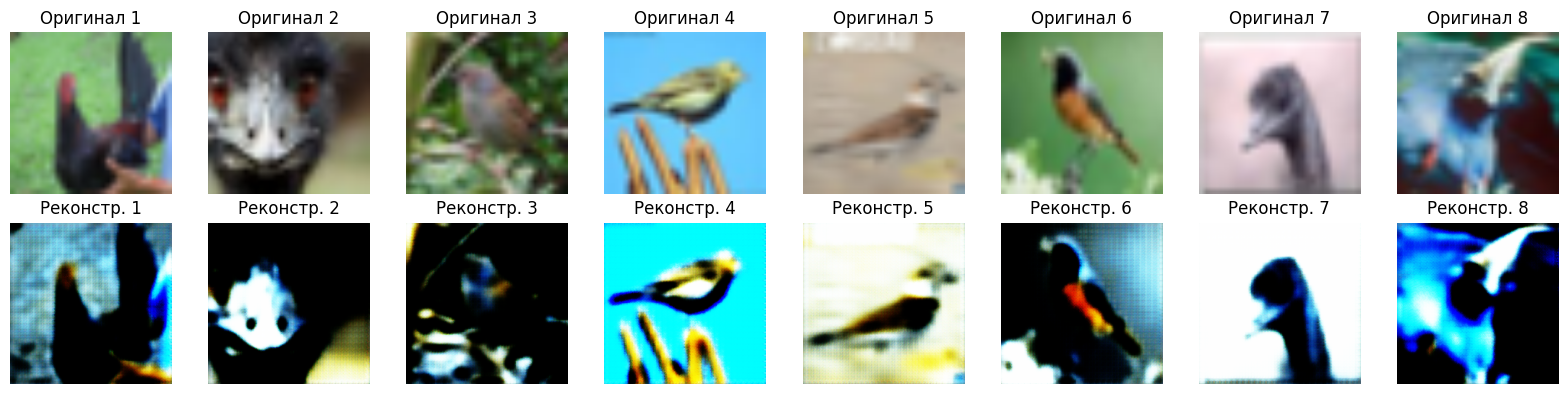

In [ ]:
# Берем несколько тестовых изображений
test_images, test_labels = next(iter(testloader))
test_images = test_images[:8].to(device)

# Получаем декодированные изображения
autoencoder.eval()
with torch.no_grad():
    reconstructed = autoencoder(test_images)
    # Подгоним размер реконструкции к входному, если не совпали spatial размеры
    if reconstructed.dim() == 4 and reconstructed.shape[-2:] != test_images.shape[-2:]:
        reconstructed = F.interpolate(reconstructed, size=test_images.shape[-2:], mode='bilinear', align_corners=False)

# Денормализация с учетом числа каналов
def denormalize_batch(t):
    t = t.detach()
    if t.dim() != 4:
        return t
    b, c, h, w = t.shape
    if c == 3:
        mean = torch.tensor([0.485, 0.456, 0.406], device=t.device).view(1, 3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225], device=t.device).view(1, 3, 1, 1)
        return t * std + mean
    elif c == 1:
        return t
    else:
        return t[:, :3]

def to_numpy_image(t):
    """
    Принимает тензор [C,H,W] или [H,W]; возвращает np.ndarray формата HxW или HxWx3.
    """
    t = t.detach().cpu()
    if t.dim() == 3:
        c, h, w = t.shape
        if c == 3:
            return t.numpy().transpose(1, 2, 0)
        elif c == 1:
            return t.squeeze(0).numpy()
        else:
            return t[:3].numpy().transpose(1, 2, 0)
    elif t.dim() == 2:
        return t.numpy()
    else:
        raise ValueError(f"Ожидался тензор 2D/3D, получено dim={t.dim()}")

# Денормализуем входы, реконструкции просто клипуем
vis_inputs = denormalize_batch(test_images).clamp(0, 1)
vis_recons = reconstructed.clamp(0, 1)

n = min(8, vis_inputs.shape[0])
fig, axes = plt.subplots(2, n, figsize=(2*n, 4))

for i in range(n):
        orig_arr = to_numpy_image(vis_inputs[i])
        recon_arr = to_numpy_image(vis_recons[i])

        # Оригинал
        if orig_arr.ndim == 2:
            axes[0, i].imshow(orig_arr, cmap='gray')
        else:
            axes[0, i].imshow(orig_arr)
        axes[0, i].set_title(f"Оригинал {i+1}")
        axes[0, i].axis('off')

        # Реконструкция
        if recon_arr.ndim == 2:
            axes[1, i].imshow(recon_arr, cmap='gray')
        else:
            axes[1, i].imshow(recon_arr)
        axes[1, i].set_title(f"Реконстр. {i+1}")
        axes[1, i].axis('off')

plt.tight_layout()
plt.show()

## Результат работы авкодировщика показывает что возможность увидеть птиц сохранилась, более того изображения стали менее щумными и более контрастными.